In [2]:
import sys
print(sys.executable)

/usr/bin/python3


In [3]:
import os
import sys
if os.getcwd().endswith('visualize'):
    os.chdir('..')
sys.path.append(os.getcwd())
from loader.dataloader import VideoDataSet,VideoDataLoader
import torch

dataset ="50salads"
split = "train.split1.bundle"
default_path="./data/data/"
knows = 11
unknowns = 8
prototypes = 30
video_dataset = VideoDataSet(dataset=dataset,
                               split=split,
                               default_path=default_path,
                               knowns=knows,
                               unknowns=unknowns,
                               total_classes=knows + prototypes)
data_loader = VideoDataLoader(video_dataset, batch_size=1, shuffle=True)

In [ ]:
from model.bert import ActionBERT, ActionBERTConfig

knowns = 14
unknowns = 5
prototypes = 30
bert_conf = ActionBERTConfig(
    total_classes=knowns + prototypes,
    input_dim=2048,
    d_model=32,
    num_heads=2,
    num_layers=4,
    ffn_dim=128,
    dropout=0.1)
model = ActionBERT(config=bert_conf)
path = "./output/actionbert_first_try.pth"


state_dict = torch.load(path, map_location=torch.device('cuda'))
model.load_state_dict(state_dict, strict=False)
model = model.to('cuda')
model.eval()
print("Modell erfolgreich geladen.")

def get_model_pred(features,padding_mask):
    unknown_mask = torch.zeros_like(padding_mask).bool()
    print(unknown_mask)
    _, _, boundaries  = model(features,unknown_mask,padding_mask)
    pred_dist_start = torch.exp(boundaries[:, :, 0]) - 1
    pred_dist_end   = torch.exp(boundaries[:, :, 1]) - 1
   # pred_dist_start = torch.clamp(pred_dist_start, min=0)
    #pred_dist_end   = torch.clamp(pred_dist_end, min=0)
    
    B, T = pred_dist_start.shape
    device = pred_dist_start.device
    
   
    t_indices = torch.arange(T, device=device).unsqueeze(0).expand(B, T)
    vote_start = torch.round(t_indices - pred_dist_start).long()
    vote_end   = torch.round(t_indices + pred_dist_end ).long()
    
    print(pred_dist_start[:, 50:100])
    
    
    

Modell erfolgreich geladen.


In [6]:
for batch in data_loader:
    features = batch["features"]
    unknown_mask = batch["unknown_mask"]
    target_truth = batch["target_truth"]
    padding_mask = batch["padding_mask"]
    labels_dict = batch["labels_dict"]
    target_start = batch['target_start']
    target_end = batch['target_end']
   
    
    break

Target tensor([[0.0000, 0.6931, 1.0986, 1.3863, 1.6094, 1.7918, 1.9459, 2.0794, 2.1972,
         2.3026, 2.3979, 2.4849, 2.5649, 2.6391, 2.7081, 2.7726, 2.8332, 2.8904,
         2.9444, 2.9957]])
tensor([[False, False, False,  ..., False, False, False]], device='cuda:0')
tensor([[102.4033, 100.4572, 101.9723, 101.8452, 100.3165, 105.2953,  95.9273,
          94.8832,  90.4017,  93.3258,  87.4778,  93.2766,  90.0590, 100.5695,
          98.5850, 102.2786, 104.2324, 109.1302,  98.3670, 101.8369]],
       device='cuda:0', grad_fn=<SliceBackward0>)


/tmp/ipykernel_185244/2785959630.py:70: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


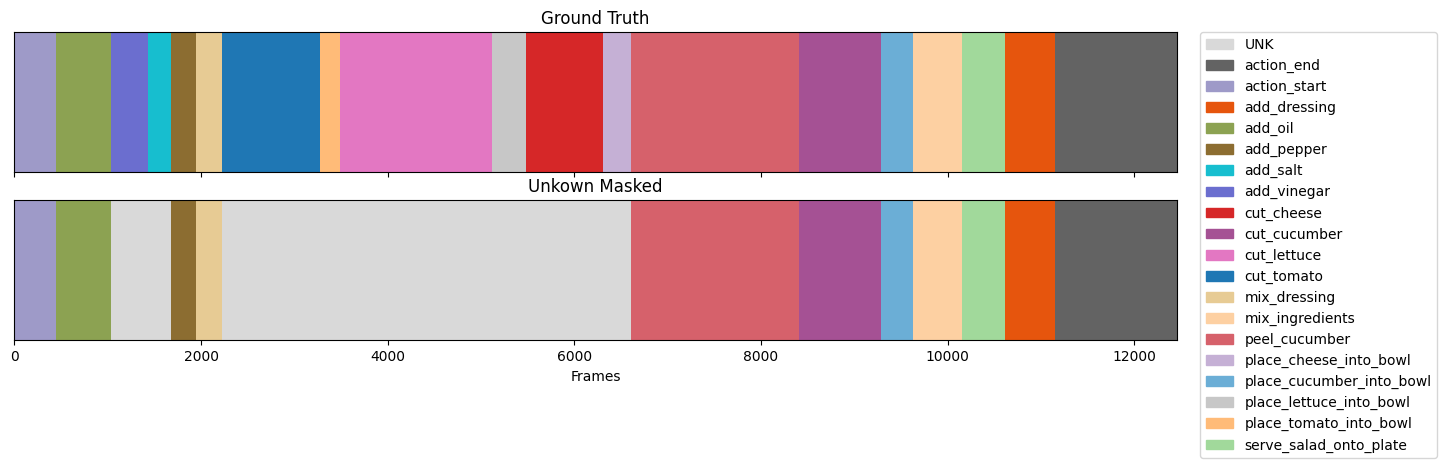

In [7]:

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

print("Target",target_start[:, :20])
get_model_pred(features.to('cuda'),padding_mask.to('cuda'))
    
    
    

colors1 = plt.get_cmap('tab20').colors
colors2 = plt.get_cmap('tab20b').colors
colors3 = plt.get_cmap('tab20c').colors

all_colors = np.vstack((colors1, colors2, colors3)) # ergibt 60 Farben

cmap = ListedColormap(all_colors, name='custom_tab60')

target_truth = target_truth[padding_mask]
unknown_mask = unknown_mask[padding_mask]
unkowns_classes = target_truth.clone().detach()
unkowns_classes[unknown_mask] = 19
plots_data = [
    ("Ground Truth", target_truth),      
    ("Unkown Masked", unkowns_classes),
]

num_plots = len(plots_data)
fig, axs = plt.subplots(nrows=num_plots, ncols=1, figsize=(15, 2 * num_plots), sharex=True)

if num_plots == 1:
    axs = [axs]

TOTAL_CLASSES = len(labels_dict)

for i, (title, tensor_data) in enumerate(plots_data):
    if isinstance(tensor_data, torch.Tensor):
        data_np = tensor_data.cpu().numpy()
    else:
        data_np = tensor_data
        
    if data_np.ndim == 1:
        data_np = data_np.reshape(1, -1)
    
   
    axs[i].imshow(data_np, aspect='auto', cmap=cmap, interpolation='nearest', 
                  vmin=0, vmax=TOTAL_CLASSES-1)
    
    axs[i].set_title(title)
    axs[i].set_yticks([]) 
    

    if i == num_plots - 1:
        axs[i].set_xlabel("Frames")

patches = []
sorted_keys = sorted(labels_dict.keys())

for key in sorted_keys:
    color = cmap(labels_dict[key] / (TOTAL_CLASSES - 1))
    
    label_name = f"{key}"
    patch = mpatches.Patch(color=color, label=label_name)
    patches.append(patch)

axs[0].legend(handles=patches, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()